This notebook focuses on addressing feedback related to the model training and evaluation process.

We begin by preparing two datasets:

1. A downsampled dataset used for training

2. The full original dataset (without downsampling) used for testing

From both datasets, we extract command embeddings, which are then used as input features for a linear regression model trained.

To evaluate the model's performance, we visualize predictions using hexbin plots— both at full scale and zoomed-in—to assess how well predicted memory usage aligns with actual usage (converted from MB to GB). 

To dig deeper:

We looked into how useful the model would be in practice. 
    
We look at how many predictions would lead to successful jobs (i.e., not memory exceeded) and how many would fail. 
    
Interestingly, we find that nearly 50% of jobs would fail if we trusted our (naive)model's predictions.

Finally, for the jobs that would succeed, we calculate how much memory we’d actually save, and plot that too. 
    
This can give us a clearer idea of the potential benefit (or risk) of relying on a simple linear regression for memory prediction.

In [ ]:
#generating Embeddings for df with downsampling for training
df_with_downsample['Embeddings']= df_with_downsample['Command'].apply(lambda x : get_embedding(x))

In [17]:
def prepare_data(df):
    X = np.array([np.array([tensor.item() for tensor in emb[0]]) for emb in df["Embeddings"]])
    y = df["MAX_MEM_USAGE_MB"].values
    
    return X, y
X_train, y_train, = prepare_data(df_with_downsample)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: (69648, 768), y_train shape: (69648,)


In [18]:
def train_model(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model
model = train_model(X_train, y_train)

In [70]:
def evaluate_model(model, X, y, dataset_label=""):
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred) 

    print(f"{dataset_label} R²: {r2:.4f}")
    print(f"{dataset_label} RMSE: {rmse:.4f}")

    return y_pred, r2
y_train_pred, r2 = evaluate_model(model, X_train, y_train, "Train")

Train R²: 0.8183
Train RMSE: 12108.1949


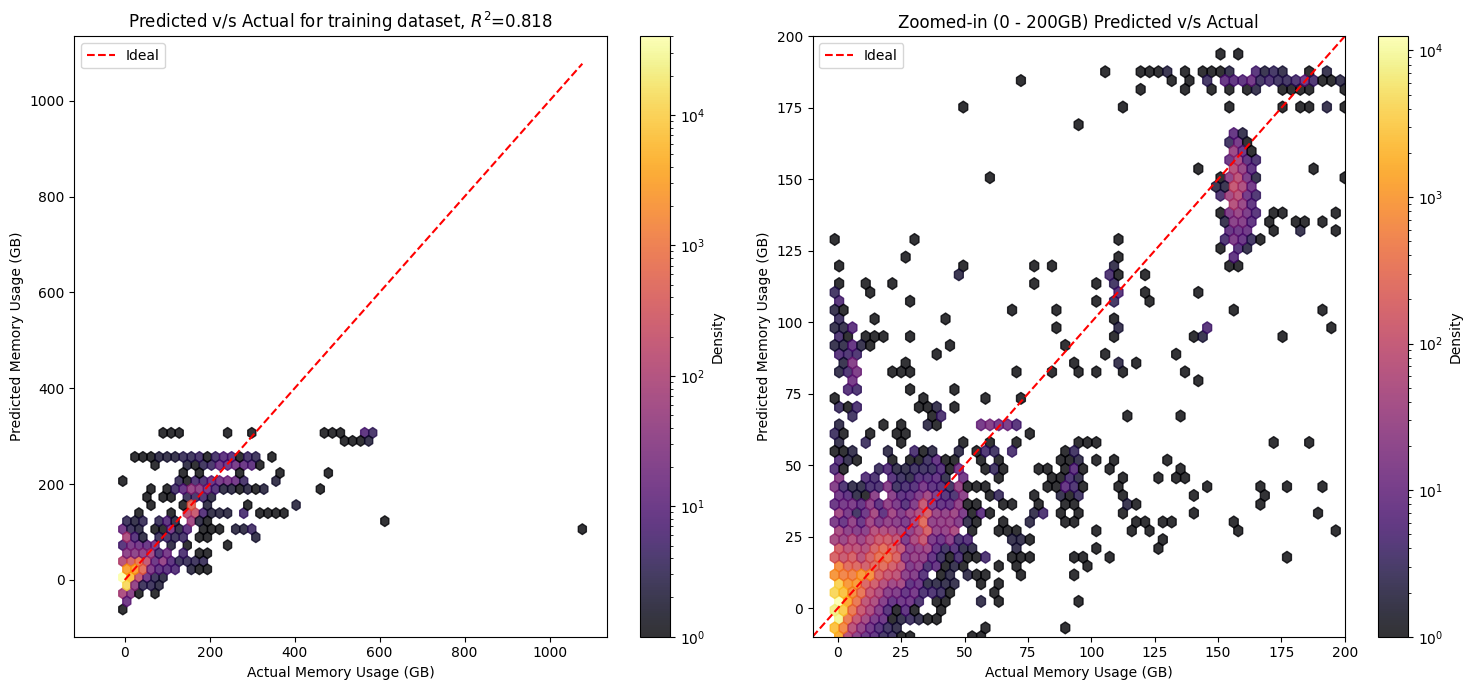

In [ ]:
# First subplot: full plot
# Second subplot: zoomed-in plot (0 to max_zoom)

In [84]:
df4 = df_with_downsample.copy()
df4["predicted_memory_mb"] = y_train_pred
# Find how many predictions will yield successful job (not memory exceeded)
df5 = df4[df4["predicted_memory_mb"] > df4["MAX_MEM_USAGE_MB"]]
print(len(df5))


34914


In [ ]:
# 50% of jobs would fail if we use the naiive linear regression model
len(df5) / len(df4)

0.5012922122674018

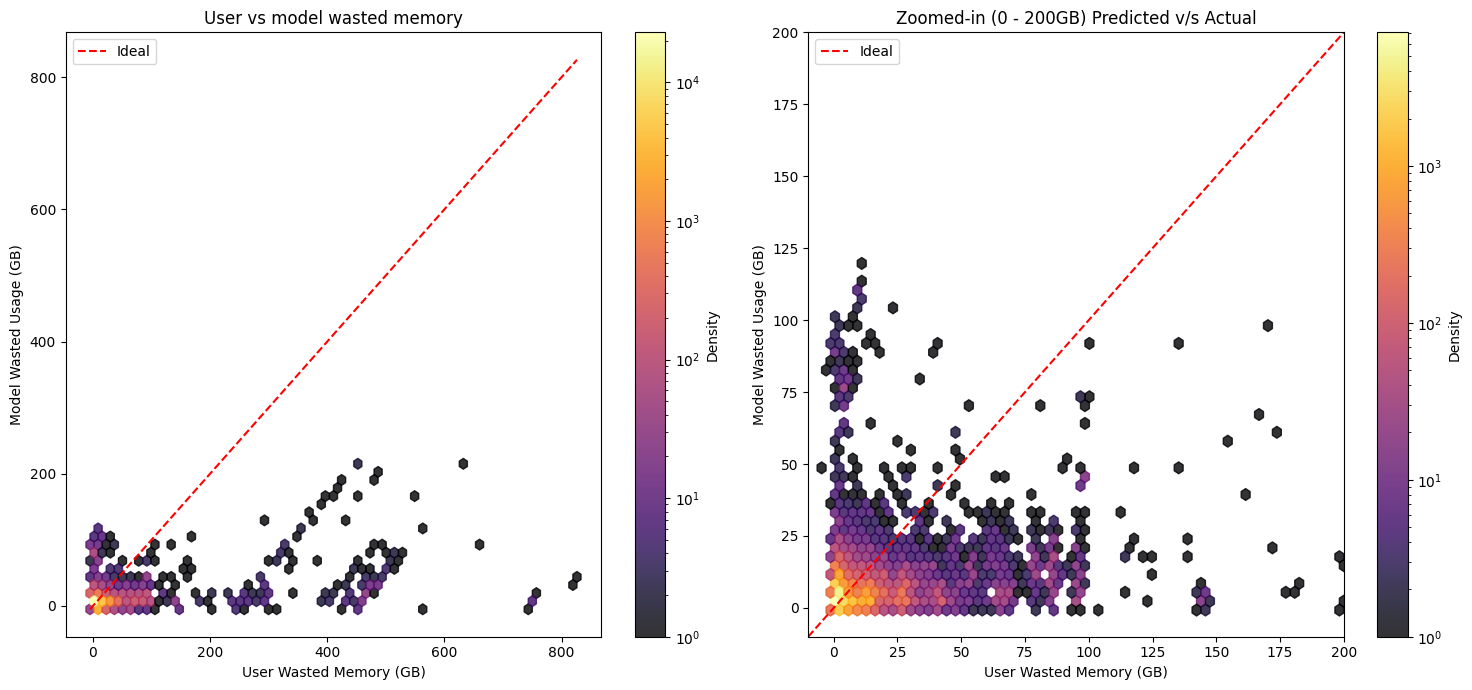

In [93]:
# For the jobs that are successful, how many MB are we saving?
wasted_memory_user = (df5["MEM_REQUESTED_MB"] - df5["MAX_MEM_USAGE_MB"])/1024
wasted_memory_model = (df5["predicted_memory_mb"] - df5["MAX_MEM_USAGE_MB"])/1024
plot_hexagonal(wasted_memory_user, wasted_memory_model, xtitle="User Wasted Memory (GB)", ytitle="Model Wasted Usage (GB)",
                   plot_title="User vs model wasted memory", max_zoom=200)

In [96]:
# Average saved memory 
average_saved = np.mean(wasted_memory_user - wasted_memory_model )
print("Average saved {:.3f} GB across {} runs".format(average_saved, len(df5)))

Average saved 5.776 GB across 34914 runs
